# Init

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from astropy.visualization import simple_norm
import photutils
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.segmentation import detect_sources
from scipy import stats
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from photutils.detection import DAOStarFinder
from astroquery.gaia import Gaia
import pandas as pd
import subprocess
import shutil
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from pathlib import Path
from scipy.stats import siegelslopes

# Load files

In [3]:
init_path = Path("/mnt/c/Users/catal/Downloads/unistellar_observations/20260202T182019_864/dark_subtracted")


solved_files = list(init_path.rglob("*.new"))

print(f"Found {len(solved_files)} solved files.")

for file in solved_files:
    with fits.open(file) as hdul:
        print(file.name, hdul[0].data.shape)

Found 26 solved files.
20260202T182028_047_StackInput_DarkSubtracted.new (976, 1304)
20260202T182032_019_StackInput_DarkSubtracted.new (976, 1304)
20260202T182035_990_StackInput_DarkSubtracted.new (976, 1304)
20260202T182039_962_StackInput_DarkSubtracted.new (976, 1304)
20260202T182043_934_StackInput_DarkSubtracted.new (976, 1304)
20260202T182047_906_StackInput_DarkSubtracted.new (976, 1304)
20260202T182051_878_StackInput_DarkSubtracted.new (976, 1304)
20260202T182055_849_StackInput_DarkSubtracted.new (976, 1304)
20260202T182059_821_StackInput_DarkSubtracted.new (976, 1304)
20260202T182103_793_StackInput_DarkSubtracted.new (976, 1304)
20260202T182107_765_StackInput_DarkSubtracted.new (976, 1304)
20260202T182111_737_StackInput_DarkSubtracted.new (976, 1304)
20260202T182115_708_StackInput_DarkSubtracted.new (976, 1304)
20260202T182119_680_StackInput_DarkSubtracted.new (976, 1304)
20260202T182123_652_StackInput_DarkSubtracted.new (976, 1304)
20260202T182127_624_StackInput_DarkSubtracted.n

In [18]:
init_path =  Path("/mnt/c/Users/catal/Downloads/unistellar_observations/20260202T182019_864/dark_subtracted")

fits_files = list(init_path.rglob("*.new"))

#print(f"Found {len(fits_files)} FITS files.")

rows = []

for file in fits_files:
    try:
        with fits.open(file) as hdul:
            header = hdul[0].header

            # Extract values safely (BIASLVL might not exist in all files)
            bias = header.get("BZERO")
            exptime = header.get("EXPTIME")
            gain = header.get("GAIN")

            obs_time = Time(header["DATE-OBS"], format="isot", scale="utc")

            location = EarthLocation(
                lat=header["LATITUDE"] * u.deg,
                lon=header["LONGITUD"] * u.deg,
                height=header.get("ALTITUDE", 0) * u.m
            )

            rows.append({
                "filename": file.name,
                "bias": bias,
                "exptime": exptime,
                "gain": gain,
                "obs_time": obs_time,
                "location": location
            })

    except Exception as e:
        print(f"Error reading {file.name}: {e}")

# Convert to DataFrame
df = pd.DataFrame(rows)

print(df.head())

                                            filename   bias   exptime  \
0  20260202T182028_047_StackInput_DarkSubtracted.new  32768  3.971754   
1  20260202T182032_019_StackInput_DarkSubtracted.new  32768  3.971754   
2  20260202T182035_990_StackInput_DarkSubtracted.new  32768  3.971754   
3  20260202T182039_962_StackInput_DarkSubtracted.new  32768  3.971754   
4  20260202T182043_934_StackInput_DarkSubtracted.new  32768  3.971754   

       gain                 obs_time  \
0  0.128711  2026-02-02T18:20:24.075   
1  0.128711  2026-02-02T18:20:28.047   
2  0.128711  2026-02-02T18:20:32.018   
3  0.128711  2026-02-02T18:20:35.990   
4  0.128711  2026-02-02T18:20:39.962   

                                            location  
0  (3950552.8798473445, 502120.2027838626, 496563...  
1  (3950552.8798473445, 502120.2027838626, 496563...  
2  (3950552.8798473445, 502120.2027838626, 496563...  
3  (3950552.8798473445, 502120.2027838626, 496563...  
4  (3950552.8798473445, 502120.2027838626, 49

 ## Statistics of new image

In [19]:
fits_files =  Path("/mnt/c/Users/catal/Downloads/unistellar_observations/20260202T182019_864/dark_subtracted").rglob("*.new")

rows = []

for file in fits_files:
    try:
        with fits.open(file) as hdul:
            data = hdul[0].data.astype(np.float32)

            mean, median, std = sigma_clipped_stats(data, sigma=3.0)
            mode = 3 * median - 2 * mean

            rows.append({
                "filename": file.name,
                "mean": mean,
                "median": median,
                "std": std,
                "mode": mode
            })

            print(f"{file.name}: "
                  f"Mean: {mean:.3f}, "
                  f"Median: {median:.3f}, "
                  f"Std: {std:.3f}, "
                  f"Mode: {mode:.3f} ADU")

    except Exception as e:
        print(f"Error processing {file.name}: {e}")

# Convert to DataFrame
df_stats = pd.DataFrame(rows)

print("\nSummary:")
print(df_stats.head())

20260202T182028_047_StackInput_DarkSubtracted.new: Mean: 5827.873, Median: 5874.000, Std: 1364.872, Mode: 5966.255 ADU
20260202T182032_019_StackInput_DarkSubtracted.new: Mean: 5851.980, Median: 5899.000, Std: 1368.757, Mode: 5993.040 ADU
20260202T182035_990_StackInput_DarkSubtracted.new: Mean: 5877.504, Median: 5927.000, Std: 1371.506, Mode: 6025.992 ADU
20260202T182039_962_StackInput_DarkSubtracted.new: Mean: 5880.867, Median: 5930.000, Std: 1372.915, Mode: 6028.267 ADU
20260202T182043_934_StackInput_DarkSubtracted.new: Mean: 5877.375, Median: 5926.000, Std: 1372.656, Mode: 6023.250 ADU
20260202T182047_906_StackInput_DarkSubtracted.new: Mean: 5872.310, Median: 5919.000, Std: 1370.257, Mode: 6012.381 ADU
20260202T182051_878_StackInput_DarkSubtracted.new: Mean: 5854.796, Median: 5902.000, Std: 1370.527, Mode: 5996.407 ADU
20260202T182055_849_StackInput_DarkSubtracted.new: Mean: 5845.535, Median: 5893.000, Std: 1367.850, Mode: 5987.930 ADU
20260202T182059_821_StackInput_DarkSubtracted.ne

## Use of DAOstars to find the stars inside new image coordinates

In [30]:
fits_files =  Path("/mnt/c/Users/catal/Downloads/unistellar_observations/20260202T182019_864/dark_subtracted").rglob("*.new")

all_sources = []

for file in fits_files:
    try:
        with fits.open(file) as hdul:
            header = hdul[0].header
            data = hdul[0].data.astype(np.float32)

        # Build WCS
        wcs = WCS(header)

        # Compute background stats
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)
        mode = 3 * median - 2 * mean

        # Star detection
        daofind = DAOStarFinder(fwhm=5.0, threshold=5.0 * std)
        sources = daofind(data - mode)

        if sources is None:
            print(f"No stars found in {file.name}")
            continue

        x = sources["xcentroid"]
        y = sources["ycentroid"]

        # Convert to RA/Dec
        ra, dec = wcs.all_pix2world(x, y, 0)

        image_coords = SkyCoord(ra=ra*u.deg,
                                dec=dec*u.deg,
                                frame="icrs")

        # Store everything
        for i in range(len(sources)):
            all_sources.append({
                "filename": file.name,
                "x_centroid": float(x[i]),
                "y_centroid": float(y[i]),
                "ra_deg": float(ra[i]),
                "dec_deg": float(dec[i]),
                "skycoord": image_coords[i]
            })

        print(f"{file.name}: detected {len(sources)} stars")

    except Exception as e:
        print(f"Error processing {file.name}: {e}")

# Convert to DataFrame
df_sources = pd.DataFrame(all_sources)

print("\nExtraction complete.")
print(df_sources.head())

20260202T182028_047_StackInput_DarkSubtracted.new: detected 40 stars
20260202T182032_019_StackInput_DarkSubtracted.new: detected 57 stars
20260202T182035_990_StackInput_DarkSubtracted.new: detected 45 stars
20260202T182039_962_StackInput_DarkSubtracted.new: detected 41 stars
20260202T182043_934_StackInput_DarkSubtracted.new: detected 37 stars
20260202T182047_906_StackInput_DarkSubtracted.new: detected 41 stars
20260202T182051_878_StackInput_DarkSubtracted.new: detected 48 stars
20260202T182055_849_StackInput_DarkSubtracted.new: detected 55 stars
20260202T182059_821_StackInput_DarkSubtracted.new: detected 46 stars
20260202T182103_793_StackInput_DarkSubtracted.new: detected 47 stars
20260202T182107_765_StackInput_DarkSubtracted.new: detected 39 stars
20260202T182111_737_StackInput_DarkSubtracted.new: detected 35 stars
20260202T182115_708_StackInput_DarkSubtracted.new: detected 51 stars
20260202T182119_680_StackInput_DarkSubtracted.new: detected 58 stars
20260202T182123_652_StackInput_Dar

In [31]:
# Run DAOStarFinder over bias-subtracted / WCS images and export results
fits_files =  Path("/mnt/c/Users/catal/Downloads/unistellar_observations/20260202T182019_864/dark_subtracted").rglob("*.new")


all_sources = []

for file in fits_files:
    try:
        with fits.open(file) as hdul:
            header = hdul[0].header
            data = hdul[0].data.astype(np.float32)

        # Build WCS
        wcs = WCS(header)

        # Compute background stats
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)
        mode = 3 * median - 2 * mean

        # Star detection
        daofind = DAOStarFinder(fwhm=5.0, threshold=5.0 * std)
        sources = daofind(data - mode)

        if sources is None:
            print(f"No stars found in {file.name}")
            continue

        x = sources["xcentroid"]
        y = sources["ycentroid"]

        # Convert to RA/Dec
        ra, dec = wcs.all_pix2world(x, y, 0)

        # Store everything
        for i in range(len(sources)):
            all_sources.append({
                "filename": file.name,
                "x_centroid": float(x[i]),
                "y_centroid": float(y[i]),
                "ra_deg": float(ra[i]),
                "dec_deg": float(dec[i])
            })

        print(f"{file.name}: detected {len(sources)} stars")

    except Exception as e:
        print(f"Error processing {file.name}: {e}")

# Convert to DataFrame
import pandas as pd

df_sources = pd.DataFrame(all_sources)

print("\nExtraction complete.")
print(df_sources.head())


20260202T182028_047_StackInput_DarkSubtracted.new: detected 40 stars
20260202T182032_019_StackInput_DarkSubtracted.new: detected 57 stars
20260202T182035_990_StackInput_DarkSubtracted.new: detected 45 stars
20260202T182039_962_StackInput_DarkSubtracted.new: detected 41 stars
20260202T182043_934_StackInput_DarkSubtracted.new: detected 37 stars
20260202T182047_906_StackInput_DarkSubtracted.new: detected 41 stars
20260202T182051_878_StackInput_DarkSubtracted.new: detected 48 stars
20260202T182055_849_StackInput_DarkSubtracted.new: detected 55 stars
20260202T182059_821_StackInput_DarkSubtracted.new: detected 46 stars
20260202T182103_793_StackInput_DarkSubtracted.new: detected 47 stars
20260202T182107_765_StackInput_DarkSubtracted.new: detected 39 stars
20260202T182111_737_StackInput_DarkSubtracted.new: detected 35 stars
20260202T182115_708_StackInput_DarkSubtracted.new: detected 51 stars
20260202T182119_680_StackInput_DarkSubtracted.new: detected 58 stars
20260202T182123_652_StackInput_Dar

## Plot to check the matched centroids

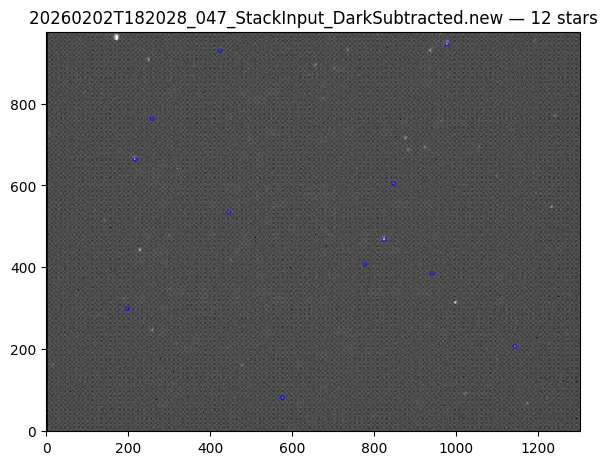

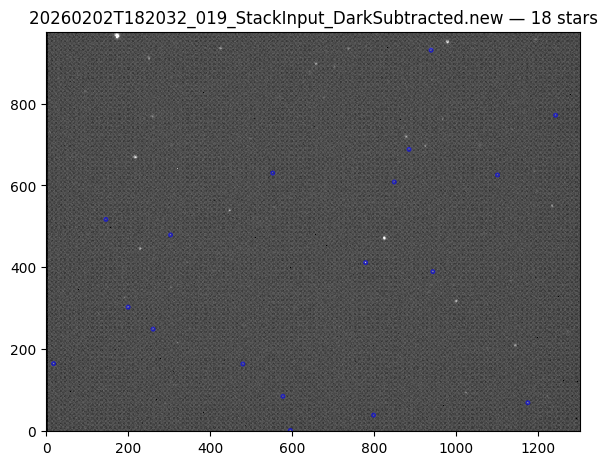

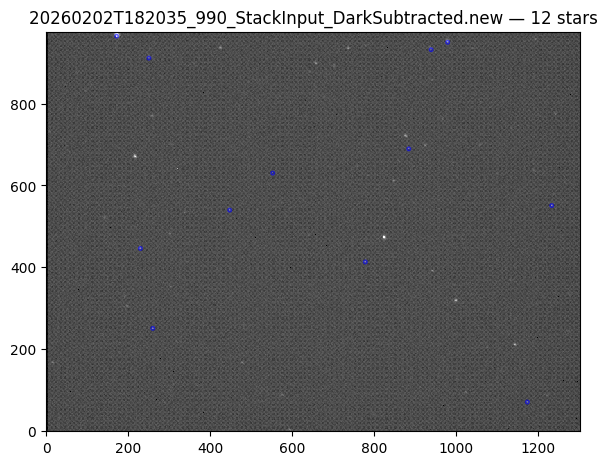

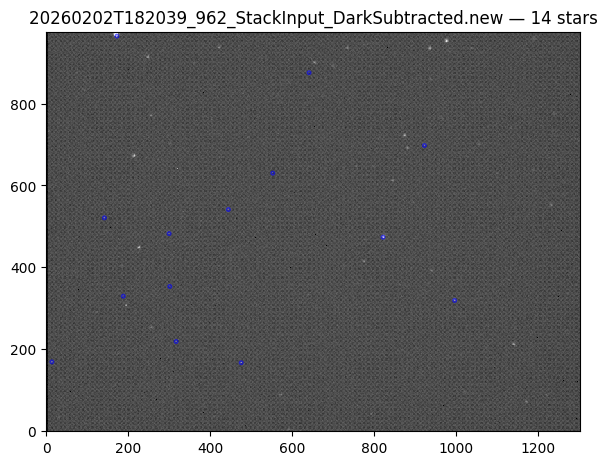

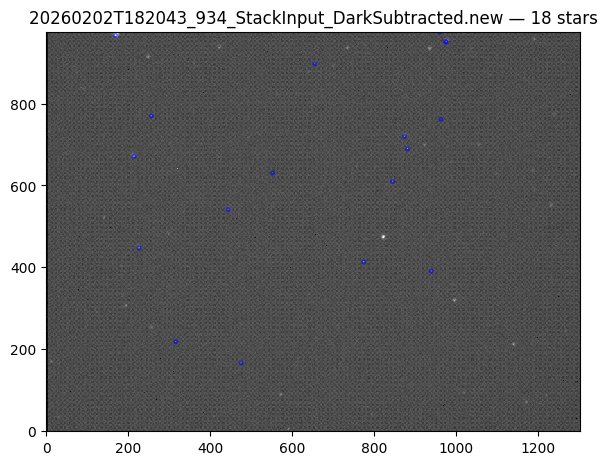

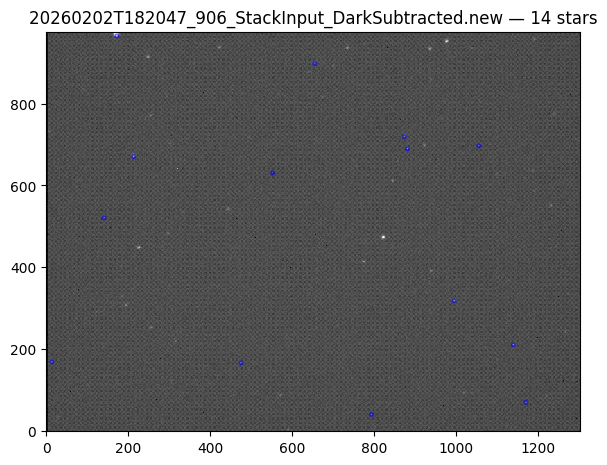

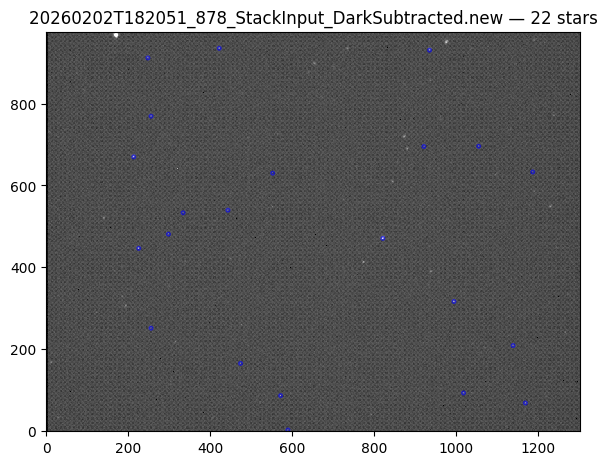

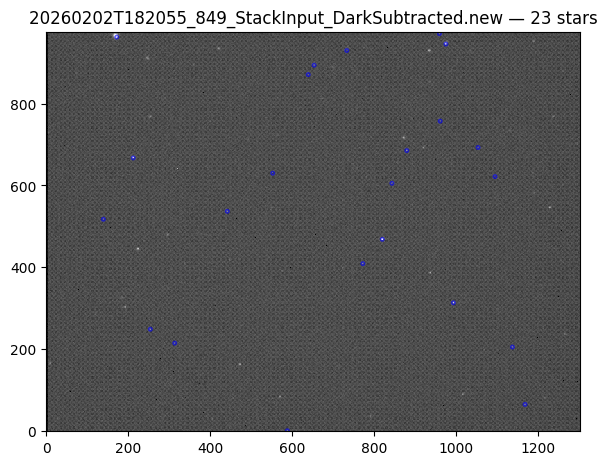

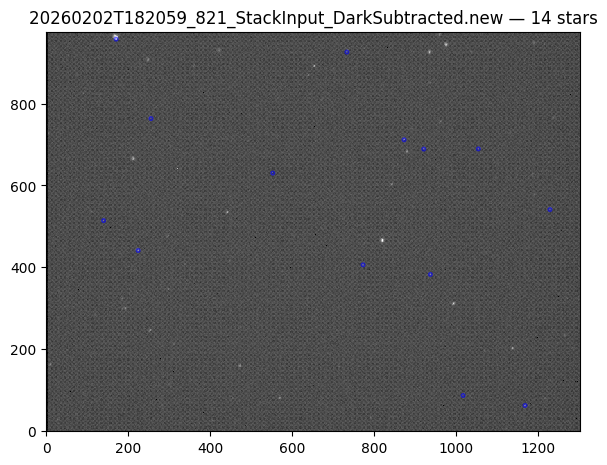

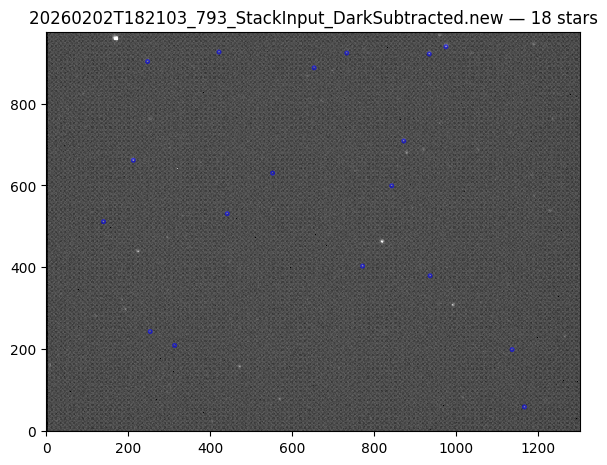

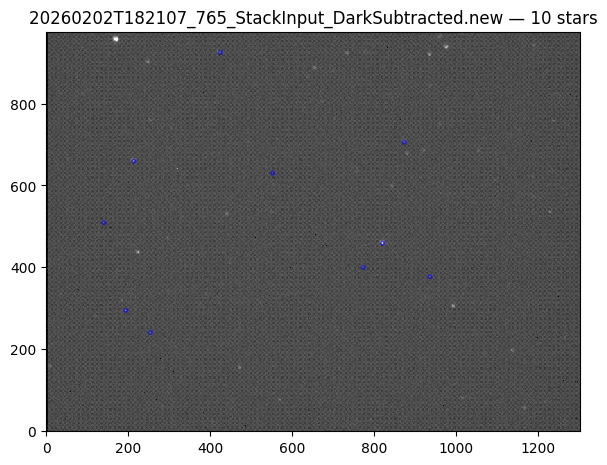

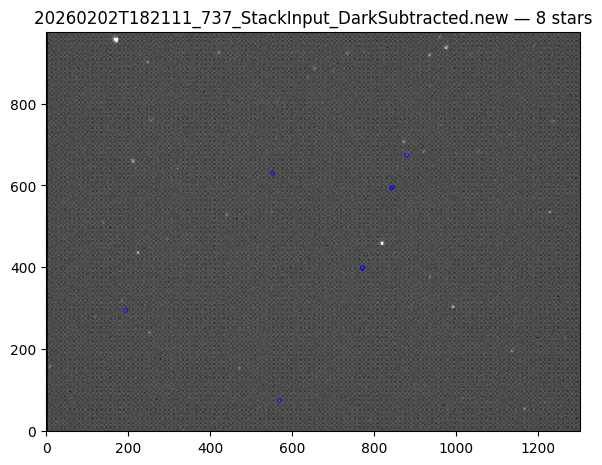

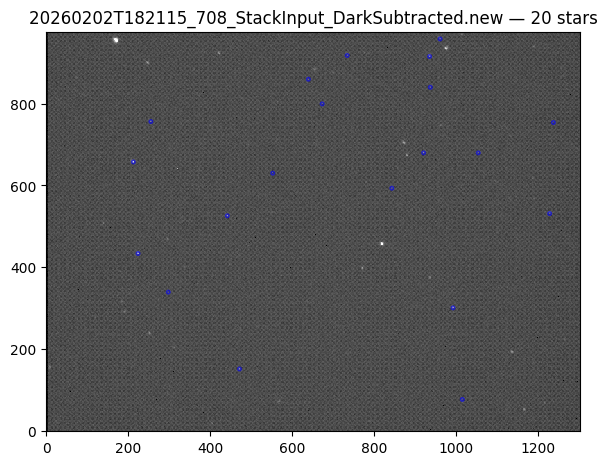

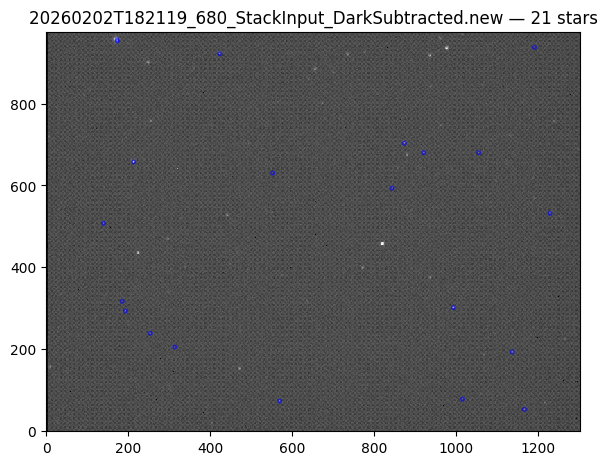

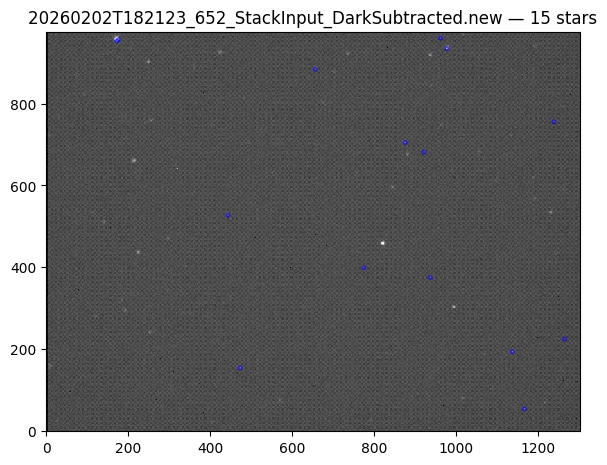

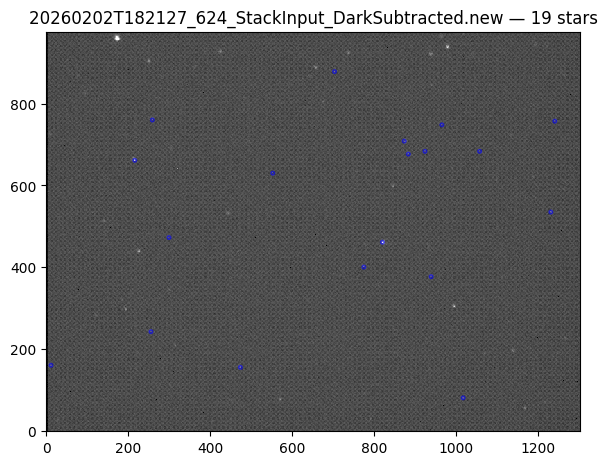

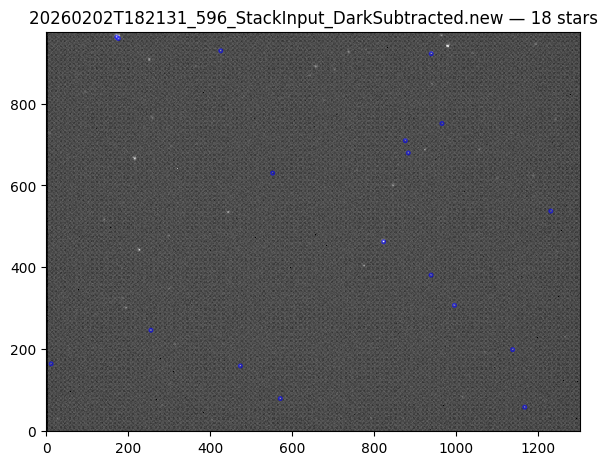

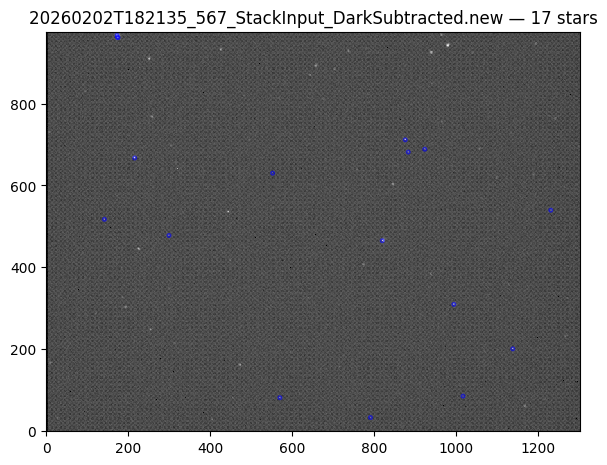

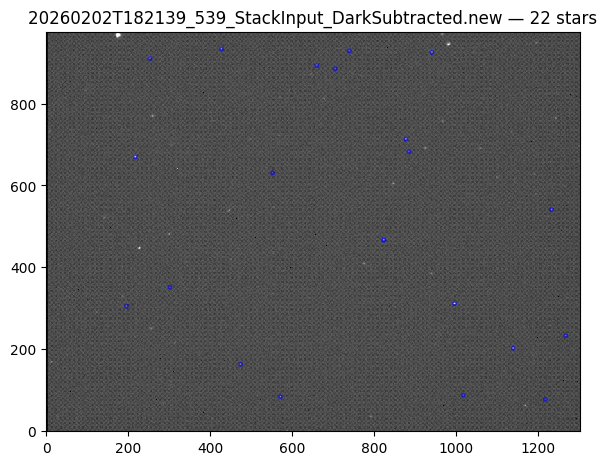

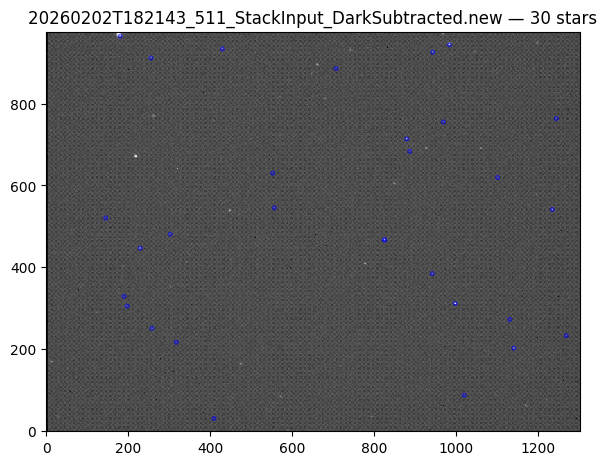

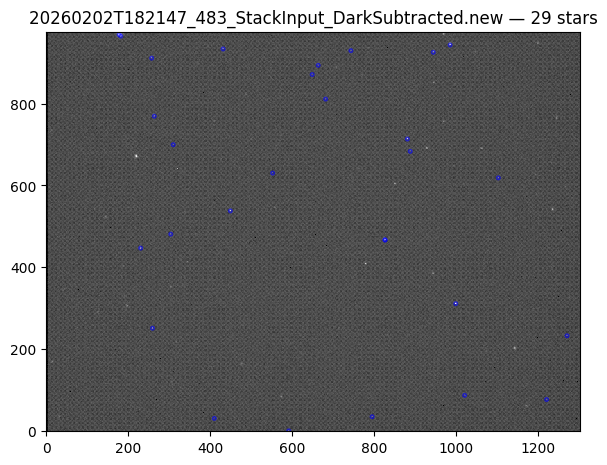

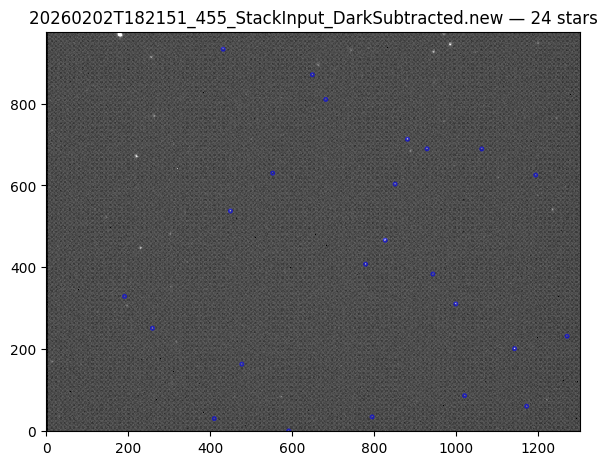

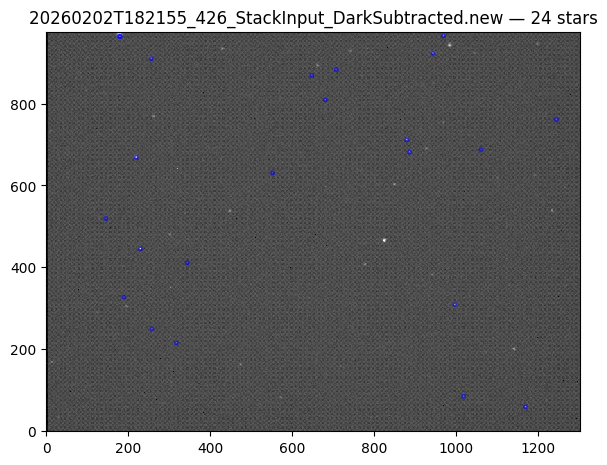

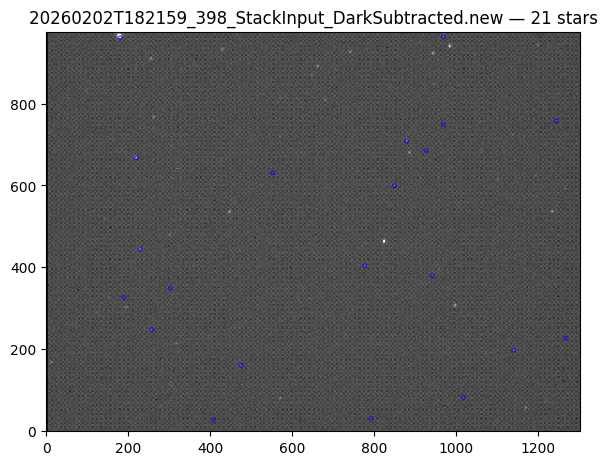

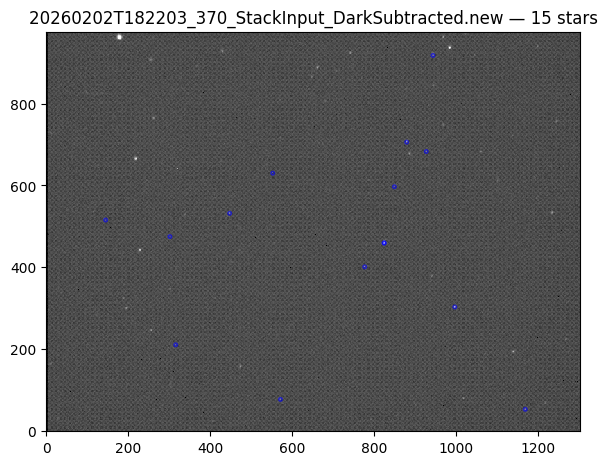

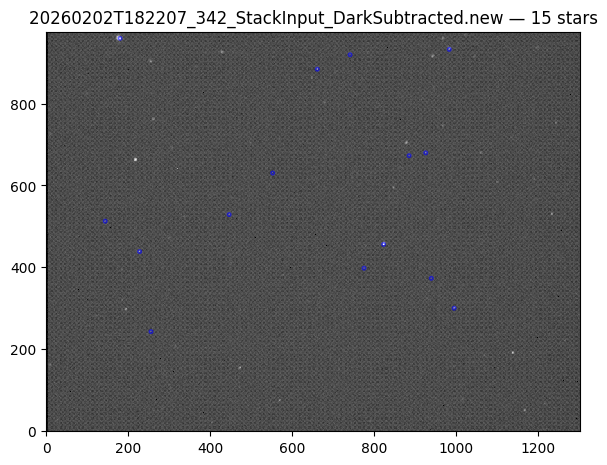

In [25]:
from photutils.aperture import CircularAperture


fits_files =  Path("/mnt/c/Users/catal/Downloads/unistellar_observations/20260202T182019_864/dark_subtracted").rglob("*.new")

for file in fits_files:

    with fits.open(file) as hdul:
        data = hdul[0].data.astype(np.float32)

    # Background stats
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    mode = 3 * median - 2 * mean

    # Detect stars
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * std)
    sources = daofind(data - mode)

    if sources is None:
        print(f"No stars found in {file.name}")
        continue

    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=4.0)

    # Plot
    plt.figure(figsize=(6, 5))
    norm = ImageNormalize(data, stretch=SqrtStretch())

    plt.imshow(data, cmap='gray', origin='lower',
               norm=norm, interpolation='nearest')

    apertures.plot(color='blue', lw=1.2, alpha=0.6)

    plt.title(f"{file.name} — {len(sources)} stars")
    plt.tight_layout()
    plt.show()

## Gaia extraction

In [9]:
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection=wcs)
# ax.imshow(data_wcs, origin='lower', cmap='gray', norm=norm)
# ax.set_xlabel('Right Ascension (J2000)')
# ax.set_ylabel('Declination (J2000)')
# ax.set_title('FITS Image with WCS')
# ax.grid(color='white', ls='dotted')
# plt.show()

In [32]:
sources

<QTable length=48>
  id      xcentroid      ...     mag          daofind_mag     
int64      float64       ...   float32          float64       
----- ------------------ ... ----------- ---------------------
    1 405.55465789166095 ...   -12.21033  -0.38987817933862684
    2  791.2185320297318 ... -12.1760235  -0.34390684407598304
    3  1168.163098882526 ...  -13.166508   -1.0457080075066236
    4 1217.1727000403598 ...  -12.284216  -0.37358806191234467
    5 454.40114929997674 ...   -11.77844  -0.07027988345402268
    6  570.3304491839649 ...   -13.27957   -1.2411951858286883
    7  473.5324667981283 ...  -13.516222   -1.4731390366711787
    8  1070.537437845273 ...  -11.829756  -0.31327707314322895
    9  1139.487566563427 ...  -14.009909   -1.8066071867568454
  ...                ... ...         ...                   ...
   39  706.9602590996886 ...  -12.456627   -0.2195039246525486
   40  661.9026573680121 ...  -13.810373   -1.5046339505229582
   41 255.36397982885615 ...   -13.94515   -1.3071532822008307
   42  943.2803921856067 ...  -14.111138   -1.5888998670993746
   43   784.190902166151 ...  -11.661062 -0.001982009331882756
   44  984.1575071079857 ...  -14.898088    -2.291183049100769
   45 1198.3877206613708 ...  -12.671513   -0.3598909037646925
   46 179.05092716251744 ...   -15.73402   -2.0477426351005716
   47 179.25703672955706 ...  -15.665393    -2.125088961846629
   48 1022.7821623573973 ...  -12.426889  -0.42301022123509563

# Gaia crossmatch

In [34]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = 10000

fits_files =  Path("/mnt/c/Users/catal/Downloads/unistellar_observations/20260202T182019_864/dark_subtracted").rglob("*.new")

matched_sources = []

# Loop over each bias-subtracted FITS image
for file in fits_files:

    # Open FITS
    with fits.open(file) as hdul:
        header = hdul[0].header
        data = hdul[0].data.astype(np.float32)

    # Build WCS
    wcs = WCS(header)

    # Background stats
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    mode = 3 * median - 2 * mean

    # Detect stars
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * std)
    sources = daofind(data - mode)

    if sources is None:
        print(f"No stars found in {file.name}")
        continue

    x = sources["xcentroid"]
    y = sources["ycentroid"]
    flux = sources["flux"]
    mag_inst = sources["mag"]

    # Convert to RA/Dec
    ra, dec = wcs.all_pix2world(x, y, 0)
    image_coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)

    # Gaia query
    center_coord = SkyCoord(np.mean(ra)*u.deg, np.mean(dec)*u.deg)
    radius = 0.4 * u.deg

    print(f"Querying Gaia for {file.name}...")
    job = Gaia.cone_search_async(coordinate=center_coord, radius=radius)
    gaia_table = job.get_results()

    if len(gaia_table) == 0:
        print(f"No Gaia sources found for {file.name}")
        continue

    gaia_coords = SkyCoord(ra=gaia_table["ra"], dec=gaia_table["dec"])

    # Cross-match image stars with Gaia
    idx, sep2d, _ = image_coords.match_to_catalog_sky(gaia_coords)
    max_sep = 2.0 * u.arcsec
    good_matches = sep2d < max_sep

    for i, match in enumerate(good_matches):
        if match:
            gaia_idx = idx[i]
            matched_sources.append({
                "filename": file.name,
                "x_centroid": float(x[i]),
                "y_centroid": float(y[i]),
                "ra_image": float(ra[i]),
                "dec_image": float(dec[i]),
                "flux": float(flux[i]),
                "mag_inst": float(mag_inst[i]),
                "ra_gaia": gaia_table["ra"][gaia_idx],
                "dec_gaia": gaia_table["dec"][gaia_idx],
                "phot_g_mean_mag": gaia_table["phot_g_mean_mag"][gaia_idx],
                "separation_arcsec": sep2d[i].arcsec
            })

    print(f"{file.name}: {np.sum(good_matches)} matches found")

# Create DataFrame
df_matched = pd.DataFrame(matched_sources)
print(df_matched.head())

Querying Gaia for 20260202T182028_047_StackInput_DarkSubtracted.new...
INFO: Query finished. [astroquery.utils.tap.core]
20260202T182028_047_StackInput_DarkSubtracted.new: 11 matches found
Querying Gaia for 20260202T182032_019_StackInput_DarkSubtracted.new...
INFO: Query finished. [astroquery.utils.tap.core]
20260202T182032_019_StackInput_DarkSubtracted.new: 17 matches found
Querying Gaia for 20260202T182035_990_StackInput_DarkSubtracted.new...
INFO: Query finished. [astroquery.utils.tap.core]
20260202T182035_990_StackInput_DarkSubtracted.new: 10 matches found
Querying Gaia for 20260202T182039_962_StackInput_DarkSubtracted.new...
INFO: Query finished. [astroquery.utils.tap.core]
20260202T182039_962_StackInput_DarkSubtracted.new: 12 matches found
Querying Gaia for 20260202T182043_934_StackInput_DarkSubtracted.new...
INFO: Query finished. [astroquery.utils.tap.core]
20260202T182043_934_StackInput_DarkSubtracted.new: 13 matches found
Querying Gaia for 20260202T182047_906_StackInput_DarkSu

In [35]:
df_matched.to_csv("matched_sources.csv", index=False)
df_matched['mag_inst']

0     -12.665252
1     -13.178940
2     -13.019010
3     -12.760983
4     -13.030473
         ...    
406   -13.406240
407   -13.186122
408   -13.543518
409   -13.273815
410   -14.642767
Name: mag_inst, Length: 411, dtype: float64

# Plot and fit of gaia stars magnitude and our stars magnitude

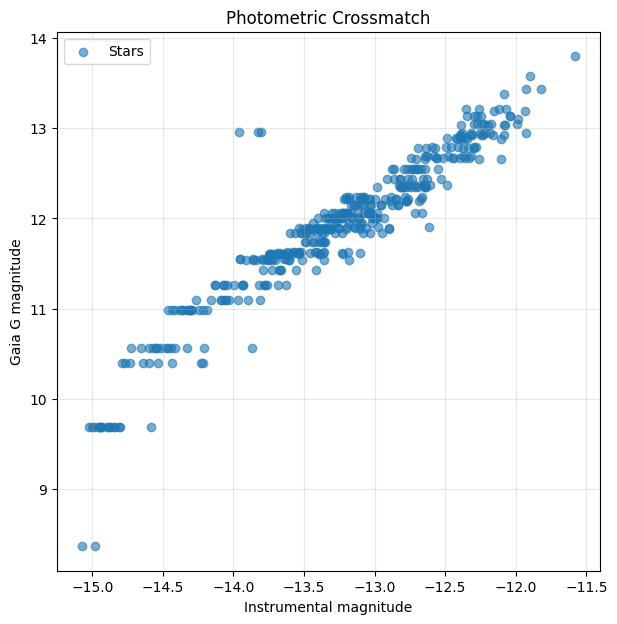

In [36]:
plt.figure(figsize=(7,7))
plt.scatter(df_matched['mag_inst'], df_matched['phot_g_mean_mag'], alpha=0.6, label='Stars')
plt.xlabel("Instrumental magnitude")
plt.ylabel("Gaia G magnitude")
plt.title("Photometric Crossmatch")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Air mass calculation 


In [67]:
airmass_list = []
delta_m_list = []

# Path where the solved / dark_subtracted files live (defined earlier in the notebook)
init_path = Path("/mnt/c/Users/catal/Downloads/unistellar_observations/20260202T182019_864/dark_subtracted")

for filename in df_matched["filename"].unique():

    image_data = df_matched[df_matched["filename"] == filename]

    # Find the full file path for this filename under init_path
    matches = list(init_path.rglob(filename))
    if len(matches) == 0:
        print(f"File not found: {filename}")
        continue
    file_path = matches[0]

    with fits.open(file_path) as hdul:
        header = hdul[0].header

    obs_time = Time(header.get("DATE-OBS"), format="isot", scale="utc")

    # Some headers use LONGITUD or LONGITUDE; fall back safely
    lon_val = header.get("LONGITUD", header.get("LONGITUDE", 0))
    location = EarthLocation(
        lat=header.get("LATITUDE", 0) * u.deg,
        lon=lon_val * u.deg,
        height=header.get("ALTITUDE", 0) * u.m
    )

    # Rebuild sky coordinates from dataframe
    coords = SkyCoord(
        ra=image_data["ra_image"].values * u.deg,
        dec=image_data["dec_image"].values * u.deg
    )

    altaz_frame = AltAz(obstime=obs_time, location=location)
    altaz = coords.transform_to(altaz_frame)

    # Compute airmass robustly: sec(z) = 1 / cos(zenith_angle).
    # altaz.alt is the altitude; zenith_angle = 90deg - alt
    zenith = (90 * u.deg) - altaz.alt
    secz = 1.0 / np.cos(zenith.to(u.rad))
    X = secz.value

    # Remove bad airmass
    valid = (X > 1) & (X < 5)
    if not np.any(valid):
        continue

    delta_m = (-image_data["mag_inst"].values[valid] + image_data["phot_g_mean_mag"].values[valid])

    airmass_list.extend(X[valid])
    delta_m_list.extend(delta_m)

# Convert to arrays
airmass = np.array(airmass_list)
delta_m = np.array(delta_m_list)

print("Total stars used:", len(airmass))


Total stars used: 411


# From theory

$$m=-2.5\log{\left(\frac{F\times g}{t}\right)}+k\chi +Z_p$$

In [70]:
valid = np.isfinite(delta_m) & np.isfinite(airmass)

delta_m = delta_m[valid]
airmass = airmass[valid]

# 3-sigma clipping
mean = np.mean(delta_m)
std = np.std(delta_m)
clip = np.abs(delta_m - mean) < 3 * std

delta_m = delta_m[clip]
airmass = airmass[clip]

# linear fit
k, zp = np.polyfit(airmass, delta_m, 1)

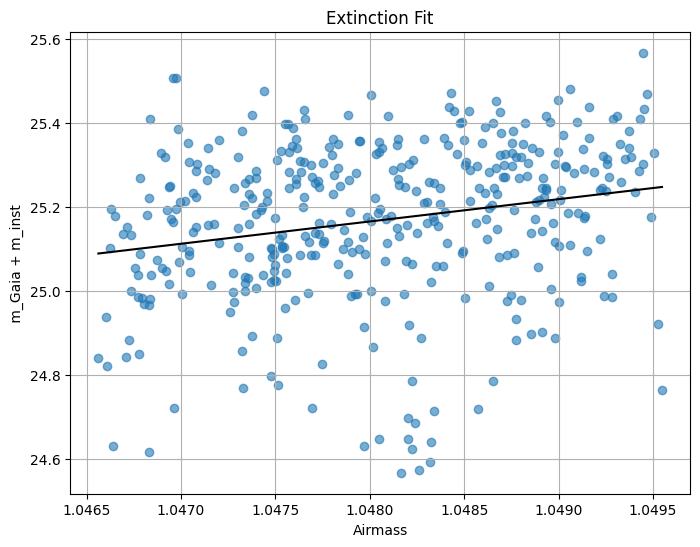

Extinction coefficient k = 53.06063896214667
Zero point ZP = -30.443044964898252


In [75]:
plt.figure(figsize=(8,6))
plt.scatter(airmass, delta_m, alpha=0.6)
x_line = np.linspace(min(airmass), max(airmass), 100)
plt.plot(x_line, k*x_line + zp, 'k')
plt.xlabel("Airmass")
plt.ylabel(" m_Gaia + m_inst ")
plt.title("Extinction Fit")
plt.grid()
plt.show()

print("Extinction coefficient k =", k)
print("Zero point ZP =", zp)
